# MIMIC-III and Support2Cls Data

## MIMIC-III

In [13]:
import copy
import numpy as np
import os
import pandas as pd
import seaborn as sns
sns.set()
sns.set_style("white")
import matplotlib.pyplot as plt

import importlib

import src.models.sklearn
import src.scripts.real_data
import src.utils.data
import src.utils.model
import src.utils.metrics
import src.utils.update

importlib.reload(src.models.sklearn)
importlib.reload(src.scripts.real_data)
importlib.reload(src.utils.data)
importlib.reload(src.utils.model)
importlib.reload(src.utils.metrics)
importlib.reload(src.utils.update)

from src.models.sklearn import lr
from src.scripts.real_data import train_update_loop, gold_standard_loop, find_threshold, results_to_dataframe, plot_rates
from src.utils.data import generate_mimic_dataset, load_mimiciii_data
from src.utils.model import get_model_fn
from src.utils.metrics import eval_model
from src.utils.update import update_model_feedback, update_model_noise

from src.utils.save import create_file_path, save_json, CONFIG_FILE

from dotenv import find_dotenv, load_dotenv
from settings import ROOT_DIR

%matplotlib inline

In [14]:
load_dotenv(find_dotenv(), override=True)
results_dir = os.environ.get("REAL_DATA_RESULTS_DIR")
results_dir = os.path.join(ROOT_DIR, results_dir)

In [15]:
num_updates = 500
train_percentage = 0.4
update_percentage = 0.4
test_percentage = 0.2
names = ["fpr", "tpr", "fnr", "tnr", "auc"]
seeds = 3
rate_types = ["fpr", "fnr"]
data_type = "mimic"
model = "lr"

### Logistic Regression

In [16]:
data = load_mimiciii_data()

In [17]:
data_fn = generate_mimic_dataset(data)

In [18]:
n_train = int(len(data["y"]) * train_percentage)
n_update = int(len(data["y"]) * update_percentage)
n_test = int(len(data["y"]) * test_percentage)

In [19]:
model_fn = get_model_fn(model)

In [20]:
desired_fpr = 0.1

In [21]:
rates = train_update_loop(model_fn, n_train, n_update, n_test, names, num_updates, desired_fpr, data_fn, seeds)

0
1
2


In [22]:
gold_standard = gold_standard_loop(model_fn, n_train, n_update, n_test, names, desired_fpr, data_fn, seeds)

In [27]:
data = results_to_dataframe(rates)

In [24]:
config = {"n_train": train_percentage, "n_update": update_percentage, "n_test": test_percentage, "num_updates": num_updates, "rate_types": rate_types, 
          "data_type": data_type, "seeds": seeds, "model": model}

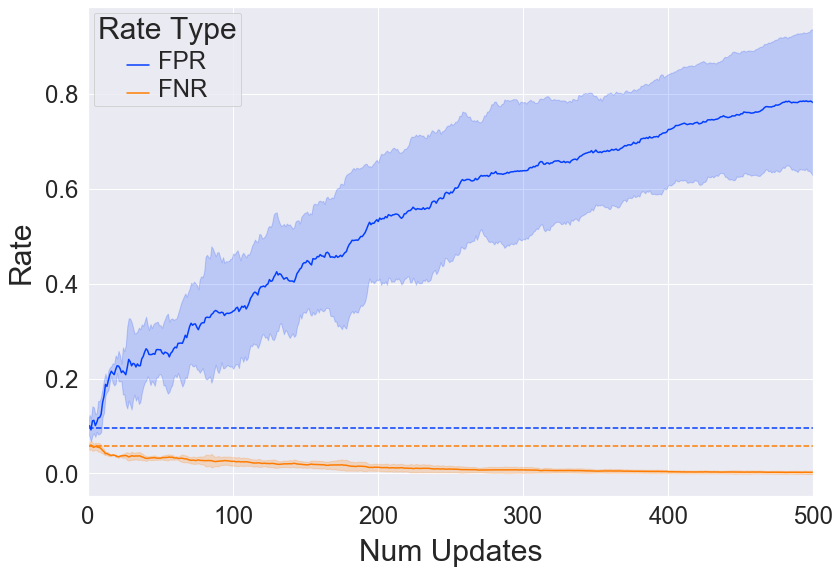

In [28]:
plot_name = "{}_{}".format(data_type, rate_types)
plot_file_name = "{}_{}".format(plot_name, "")
plot_path = os.path.join(results_dir, plot_file_name)

create_file_path(plot_path)
plot_rates(data, rate_types, [np.mean(gold_standard[key]) for key in rate_types], plot_path)

config_file_name = CONFIG_FILE.format(plot_name, "")
config_path = os.path.join(results_dir, config_file_name)
save_json(config, config_path)

## Support 2